# **Energy Consumption Predictor for a Household**

## **Problem Statement:**

Develop a predictive model to forecast daily household energy consumption using historical data. The goal is to use features such as date and time to estimate daily energy usage (measured in kWh), helping households optimize consumption and reduce waste, aligning with sustainable energy practices.

## **Importing Required Libraries:**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib

## **Dataset Overview:**

### **Dataset Details:**
* **Dataset Name:** household_power_consumption
* **source:** https://www.kaggle.com/datasets/imtkaggleteam/household-power-consumption       
* **File Format** : .csv
### **Dataset Description:**
The Household Electric Power Consumption dataset contains minute-by-minute energy consumption data from a single household in Belgium, collected over the period from 2006 to 2010. For this project, the data will be aggregated to daily totals to forecast daily energy usage, making it suitable for analyzing consumption patterns and supporting energy efficiency goals.

### **Feature Description:**
* **Date:** The date of the measurement, recorded daily.
* **Global_active_power:** The total active power consumption for the day, measured in kilowatt-hours (kWh), representing the primary energy usage metric to predict.
* **Global_reactive_power:** The reactive power consumption for the day in kWh, providing additional context on energy dynamics.
* **Voltage:** The average voltage measurement for the day, reflecting electrical conditions.
* **Global_intensity:** The average current intensity for the day, indicating electrical load.
* **Sub_metering_1:** Energy consumption of kitchen appliances in kWh, offering a breakdown of usage.
* **Sub_metering_2:** Energy consumption of laundry appliances in kWh, providing further usage segmentation.
* **Sub_metering_3:** Energy consumption of other devices (e.g., water heater, air conditioning) in kWh.

## **Loading the Dataset:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/household_power_consumption.csv')

#### **Exploring and Understanding the Data**

In [4]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0
...,...,...,...,...,...,...,...,...,...
1048570,13/12/2008,21:34:00,0.426,0.076,242.27,1.8,0,0,0.0
1048571,13/12/2008,21:35:00,0.424,0.076,242.1,1.8,0,0,0.0
1048572,13/12/2008,21:36:00,0.422,0.076,241.73,1.8,0,0,0.0
1048573,13/12/2008,21:37:00,0.422,0.078,242.56,1.8,0,0,0.0


## **Preparing Features for Modeling**

In [5]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(['Date', 'Time'], axis=1)
df_numeric = df.drop('Datetime', axis=1).apply(pd.to_numeric, errors='coerce')
df_numeric['Datetime'] = df['Datetime']
df_numeric.set_index('Datetime', inplace=True)
daily_df = df_numeric.resample('D').agg({
'Global_active_power': 'sum',
'Global_reactive_power': 'sum',
'Voltage': 'mean',
'Global_intensity': 'mean',
'Sub_metering_1': 'sum',
'Sub_metering_2': 'sum',
'Sub_metering_3': 'sum'
}).reset_index()
daily_df['Global_active_power'] = daily_df['Global_active_power'] / 60

## **Checking data summary**

In [6]:
print("Data Summary:\n", daily_df.describe())

Data Summary:
                   Datetime  Global_active_power  Global_reactive_power  \
count                  729           729.000000             729.000000   
mean   2007-12-15 00:00:00            26.463736             169.460971   
min    2006-12-16 00:00:00             0.000000               0.000000   
25%    2007-06-16 00:00:00            18.924500             135.894000   
50%    2007-12-15 00:00:00            26.271667             165.224000   
75%    2008-06-14 00:00:00            32.846033             192.446000   
max    2008-12-13 00:00:00            79.556433             392.272000   
std                    NaN            11.372870              46.400978   

          Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
count  728.000000        728.000000      729.000000      729.000000   
mean   239.944278          4.725127     1687.043896     2113.622771   
min    231.088229          0.808333        0.000000        0.000000   
25%    239.499859          3.43385

## **Filling missing values with column means**

In [7]:
daily_df = daily_df.fillna(daily_df.mean())

## **Extracting features and defining target**


In [8]:
daily_df['Day_of_Week'] = daily_df['Datetime'].dt.dayofweek
daily_df['Month'] = daily_df['Datetime'].dt.month
X = daily_df[['Day_of_Week', 'Month', 'Voltage', 'Sub_metering_1', 'Global_intensity', 'Sub_metering_2']]
y = daily_df['Global_active_power']

## **Spliting the data**


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (583, 6)
Testing set size: (146, 6)


## **Training Linear Regression model**


In [10]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
print("Linear Regression - Model Coefficients:", model_lr.coef_)
print("Linear Regression - Model Intercept:", model_lr.intercept_)

Linear Regression - Model Coefficients: [-9.85157628e-02 -3.26696634e-02  2.71194629e-01  3.25138558e-04
  5.32149237e+00  1.72281048e-04]
Linear Regression - Model Intercept: -64.1454758229305


## **Evaluating the model**


In [11]:
y_pred_lr = model_lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

In [12]:
average_consumption = y_train.mean()
print("\nEvaluation Metrics:")
print("Linear Regression - Mean Absolute Error (MAE):", mae_lr, "kWh")
print("Linear Regression - Root Mean Squared Error (RMSE):", rmse_lr, "kWh")
print("Linear Regression - MAE % of average:", (mae_lr / average_consumption) * 100, "%")
print("Linear Regression - RMSE % of average:", (rmse_lr / average_consumption) * 100, "%")



Evaluation Metrics:
Linear Regression - Mean Absolute Error (MAE): 0.8639896159410642 kWh
Linear Regression - Root Mean Squared Error (RMSE): 2.237590833256437 kWh
Linear Regression - MAE % of average: 3.303386072368465 %
Linear Regression - RMSE % of average: 8.55522596320518 %


## **Visualization of predictions**


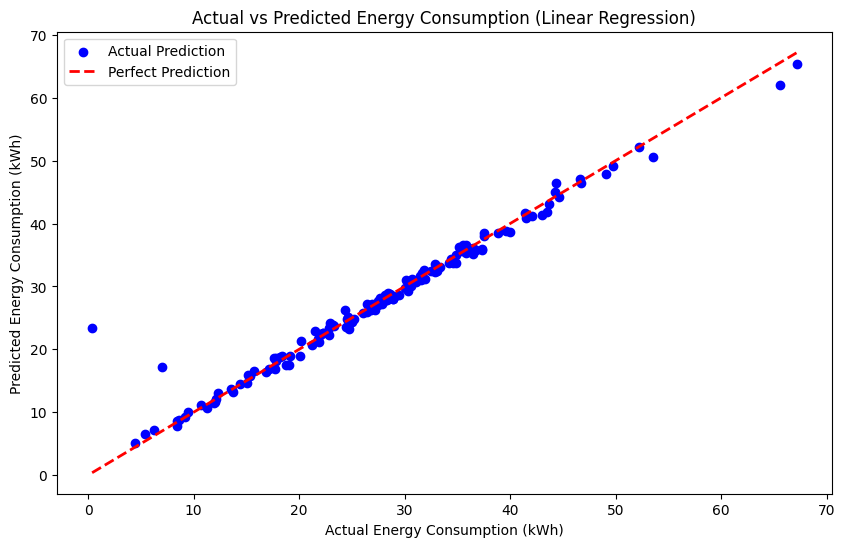

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Actual Prediction')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Energy Consumption (kWh)')
plt.ylabel('Predicted Energy Consumption (kWh)')
plt.title('Actual vs Predicted Energy Consumption (Linear Regression)')
plt.legend()
plt.show()

In [14]:
# Save the model
joblib.dump(model_lr, 'energy_consumption_model.pkl')
print("Model saved as 'energy_consumption_model.pkl'")

Model saved as 'energy_consumption_model.pkl'
